# Model Experiments: Feature Selection, Regime Analysis & Alpha Extraction

## Key Finding from Previous Notebook

| Model | Gross Sharpe | Net Sharpe | Return | Turnover |
|-------|-------------|-----------|--------|----------|
| Ridge | -0.095 | -2.44 | -24.6% | 413x |
| **LightGBM** | **0.676** | -1.93 | **139%** | 441x |
| MLP | -0.039 | -5.68 | -9.7% | 671x |

**Critical Insight**: LightGBM IS finding alpha (0.68 Sharpe, 139% return)!  
The problem is **TURNOVER** (441x annual) which destroys net returns.

## This Notebook's Goals

1. **Feature Importance Analysis** - Which features actually matter?
2. **Regime Diagnostics** - When does the model work/fail?
3. **Turnover Reduction** - Position smoothing, conviction filtering
4. **Reliability-Weighted Alpha** - Hit-ratio weighted signals

In [2]:
# =============================================================================
# SETUP & IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

import sys
sys.path.append('../src')
from pipeline import Pipeline
import torch

print("✅ Imports ready")

✅ Imports ready


In [5]:
torch.cuda.is_available()
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4050 Laptop GPU


In [37]:
# =============================================================================
# LOAD DATA (Same format as feature_family_1_momentum notebook)
# =============================================================================

# Initialize pipeline and load data from parquet
pipeline = Pipeline()
pipeline.load_data('../data/processed/df_after_eda.parquet')

# Quick access to panel data
panel = pipeline.panel
returns = panel['returns']

print(f"Data loaded: {returns.shape[0]} days x {returns.shape[1]} assets")
print(f"Date range: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPanel keys: {list(panel.keys())}")

Data loaded: 2511 days x 100 assets
Data loaded: 2511 days x 100 assets
Date range: 2016-01-25 to 2026-01-16

Panel keys: ['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'forward_returns', 'target']


---

# Part 1: Feature Engineering (Streamlined)

We'll build the same regime-conditioned features but track which ones matter.

In [8]:
# =============================================================================
# COMPUTE ALL FEATURES
# =============================================================================

def compute_all_features(returns: pd.DataFrame) -> dict:
    """Compute all features in one place for easy tracking"""
    
    features = {}
    
    # --- BASELINE ---
    features['ret_1d'] = returns.shift(1)
    features['ret_5d'] = returns.rolling(5).sum().shift(1)
    features['vol_20d'] = returns.rolling(20).std().shift(1)
    
    # --- MOMENTUM ---
    features['mom_3d'] = returns.rolling(3).sum().shift(1)
    features['mom_5d'] = returns.rolling(5).sum().shift(1)
    features['mom_10d'] = returns.rolling(10).sum().shift(1)
    
    # --- TREND REGIME (Market-level, broadcast to all assets) ---
    market_ret = returns.mean(axis=1)
    
    # Trend strength (vol-normalized 60d return)
    cumret_60 = market_ret.rolling(60).sum()
    vol_60 = market_ret.rolling(60).std() * np.sqrt(60)
    trend_strength = cumret_60 / vol_60.replace(0, np.nan)
    
    # Trend consistency (fraction of days matching trend direction)
    trend_sign = np.sign(trend_strength)
    pos_count = (market_ret > 0).rolling(60).sum()
    neg_count = (market_ret < 0).rolling(60).sum()
    trend_consistency = np.where(
        trend_sign > 0, pos_count / 60,
        np.where(trend_sign < 0, neg_count / 60, 0.5)
    )
    trend_consistency = pd.Series(trend_consistency, index=returns.index)
    
    # Trend breadth (% of stocks with positive 20d return)
    cumret_20d = returns.rolling(20).sum()
    trend_breadth = (cumret_20d > 0).mean(axis=1)
    
    # Broadcast to panel
    features['trend_strength'] = pd.DataFrame(
        np.tile(trend_strength.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    features['trend_consistency'] = pd.DataFrame(
        np.tile(trend_consistency.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    features['trend_breadth'] = pd.DataFrame(
        np.tile(trend_breadth.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    
    # --- INTERACTION TERMS ---
    features['mom_5d_x_trend'] = features['mom_5d'] * features['trend_strength']
    features['mom_5d_x_consistency'] = features['mom_5d'] * features['trend_consistency']
    features['mom_5d_x_breadth'] = features['mom_5d'] * features['trend_breadth']
    
    # Standardize all features (expanding window to avoid lookahead)
    for name in features:
        features[name] = (features[name] - features[name].expanding().mean()) / features[name].expanding().std()
    
    return features

# Compute features
print("Computing features...")
features = compute_all_features(returns)

print(f"\n📊 Feature Set ({len(features)} features):")
for name in features:
    print(f"   • {name}")

Computing features...

📊 Feature Set (12 features):
   • ret_1d
   • ret_5d
   • vol_20d
   • mom_3d
   • mom_5d
   • mom_10d
   • trend_strength
   • trend_consistency
   • trend_breadth
   • mom_5d_x_trend
   • mom_5d_x_consistency
   • mom_5d_x_breadth


---

# Part 2: Feature Importance Analysis

Which features actually contribute to predictions? Let's train a single LightGBM and analyze.

In [9]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

def analyze_feature_importance(features: dict, returns: pd.DataFrame, train_years: int = 5):
    """Train LightGBM on historical data and extract feature importance"""
    
    feature_names = list(features.keys())
    
    # Prepare data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    
    # Use first train_years for training
    train_end = train_years * 252
    train_dates = common_dates[:train_end]
    
    # Build training data
    X_list, y_list = [], []
    for date in train_dates:
        for asset in returns.columns:
            x = [features[f].loc[date, asset] for f in feature_names]
            y = returns.loc[date, asset]
            if not any(np.isnan(x)) and not np.isnan(y):
                X_list.append(x)
                y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"Training data: {len(X):,} samples")
    
    # Train LightGBM
    model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        min_child_samples=100,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=-1,
        n_jobs=-1
    )
    model.fit(X, y)
    
    # Extract importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance['pct'] = 100 * importance['importance'] / importance['importance'].sum()
    importance['cumulative_pct'] = importance['pct'].cumsum()
    
    return importance, model

# Analyze
print("Analyzing feature importance...")
importance, lgb_model = analyze_feature_importance(features, returns, train_years=5)

print("\n📊 Feature Importance Ranking:")
print("=" * 60)
for i, row in importance.iterrows():
    bar = '█' * int(row['pct'] / 2)
    print(f"{row['feature']:25s} | {row['pct']:5.1f}% | {bar}")
print("=" * 60)

Analyzing feature importance...
Training data: 126,000 samples

📊 Feature Importance Ranking:
trend_strength            |  23.8% | ███████████
trend_breadth             |  21.8% | ██████████
trend_consistency         |  20.8% | ██████████
vol_20d                   |   7.4% | ███
ret_1d                    |   6.6% | ███
mom_10d                   |   5.3% | ██
mom_5d_x_breadth          |   3.8% | █
mom_5d_x_trend            |   3.8% | █
mom_3d                    |   3.2% | █
ret_5d                    |   1.8% | 
mom_5d_x_consistency      |   1.4% | 
mom_5d                    |   0.2% | 


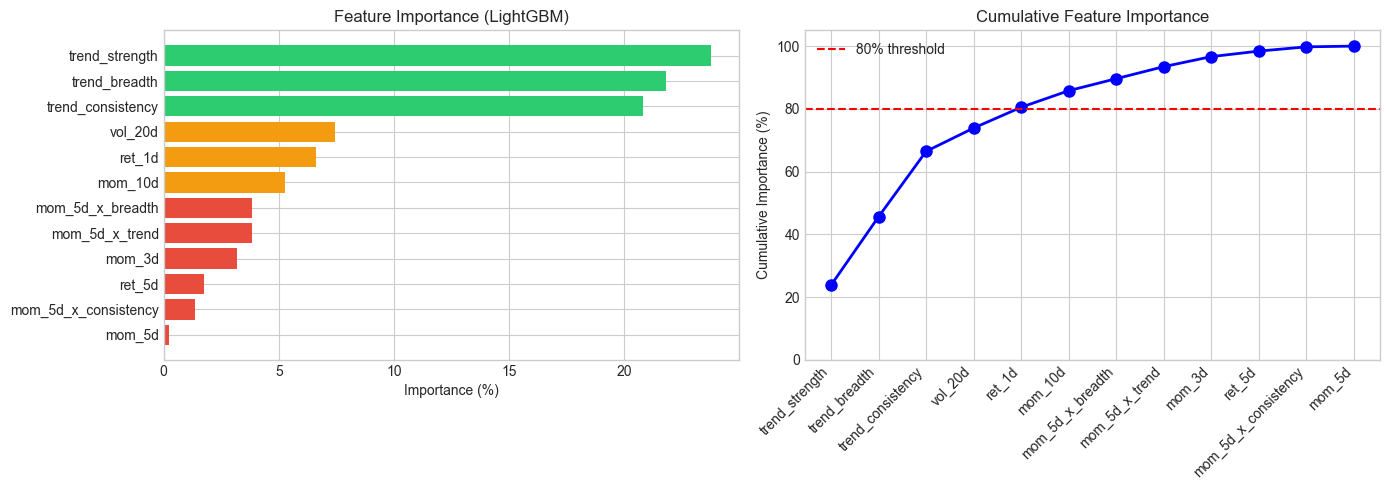


🎯 Top Features (80%+ importance): ['trend_strength', 'trend_breadth', 'trend_consistency', 'vol_20d', 'ret_1d']


In [11]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax = axes[0]
colors = ['#2ecc71' if imp > 10 else '#f39c12' if imp > 5 else '#e74c3c' 
          for imp in importance['pct']]
ax.barh(importance['feature'], importance['pct'], color=colors)
ax.set_xlabel('Importance (%)')
ax.set_title('Feature Importance (LightGBM)')
ax.invert_yaxis()

# Cumulative
ax = axes[1]
ax.plot(range(len(importance)), importance['cumulative_pct'], 'b-o', linewidth=2, markersize=8)
ax.axhline(80, color='r', linestyle='--', label='80% threshold')
ax.set_xticks(range(len(importance)))
ax.set_xticklabels(importance['feature'], rotation=45, ha='right')
ax.set_ylabel('Cumulative Importance (%)')
ax.set_title('Cumulative Feature Importance')
ax.legend()
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify top features (80% of importance)
top_features = importance[importance['cumulative_pct'] <= 85]['feature'].tolist()
print(f"\n🎯 Top Features (80%+ importance): {top_features}")

---

# Part 3: Regime-Based Performance Diagnostics

When does the model work? When does it fail?

In [12]:
# =============================================================================
# COMPUTE REGIME INDICATORS
# =============================================================================

# Market-level indicators
market_ret = returns.mean(axis=1)

# Volatility regime
vol_20d = market_ret.rolling(20).std() * np.sqrt(252)  # Annualized
vol_median = vol_20d.median()
high_vol = vol_20d > vol_median

# Trend regime (60d cumulative return)
trend_60d = market_ret.rolling(60).sum()
uptrend = trend_60d > 0

# Combine into regime DataFrame
regimes = pd.DataFrame({
    'vol_20d': vol_20d,
    'high_vol': high_vol,
    'trend_60d': trend_60d,
    'uptrend': uptrend
}, index=returns.index)

# Create 4 regime buckets
regimes['regime'] = 'Unknown'
regimes.loc[uptrend & high_vol, 'regime'] = 'Uptrend + High Vol'
regimes.loc[uptrend & ~high_vol, 'regime'] = 'Uptrend + Low Vol'
regimes.loc[~uptrend & high_vol, 'regime'] = 'Downtrend + High Vol'
regimes.loc[~uptrend & ~high_vol, 'regime'] = 'Downtrend + Low Vol'

print("📊 Regime Distribution:")
print(regimes['regime'].value_counts())

📊 Regime Distribution:
regime
Uptrend + Low Vol       1202
Uptrend + High Vol       824
Downtrend + High Vol     421
Downtrend + Low Vol       64
Name: count, dtype: int64


In [13]:
# =============================================================================
# QUICK BACKTEST FOR REGIME ANALYSIS
# =============================================================================

def quick_backtest_lgb(features, returns, train_window=252, retrain_interval=21):
    """Fast backtest returning daily returns for regime analysis"""
    
    feature_names = list(features.keys())
    F = len(feature_names)
    
    # Prepare data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    common_assets = returns.columns
    
    T = len(common_dates)
    N = len(common_assets)
    
    # Build arrays
    X_panel = np.zeros((T, N, F))
    for fi, fname in enumerate(feature_names):
        X_panel[:, :, fi] = features[fname].loc[common_dates, common_assets].values
    y_panel = returns.loc[common_dates, common_assets].values
    
    # Backtest
    daily_returns = []
    current_model = None
    
    for t in range(train_window, T):
        day_idx = t - train_window
        date = common_dates[t]
        
        # Retrain if needed
        if day_idx % retrain_interval == 0 or current_model is None:
            X_train = X_panel[t-train_window:t].reshape(-1, F)
            y_train = y_panel[t-train_window:t].flatten()
            valid = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
            
            current_model = lgb.LGBMRegressor(
                n_estimators=50, max_depth=3, learning_rate=0.1,
                min_child_samples=100, verbosity=-1, n_jobs=-1
            )
            current_model.fit(X_train[valid], y_train[valid])
        
        # Predict
        X_test = X_panel[t]
        valid_test = ~np.isnan(X_test).any(axis=1)
        pred = current_model.predict(X_test)
        pred[~valid_test] = np.nan
        
        # Long-short portfolio
        pred_clean = pd.Series(pred, index=common_assets).dropna()
        if len(pred_clean) < 10:
            continue
        
        n_long = max(1, int(len(pred_clean) * 0.2))
        ranks = pred_clean.rank(ascending=False)
        long_mask = ranks <= n_long
        short_mask = ranks > len(pred_clean) - n_long
        
        actual_ret = returns.loc[date, pred_clean.index]
        port_ret = (actual_ret[long_mask].mean() - actual_ret[short_mask].mean())
        
        daily_returns.append({'date': date, 'return': port_ret})
        
        if (day_idx + 1) % 500 == 0:
            print(f"   Day {day_idx + 1}/{T - train_window}")
    
    return pd.DataFrame(daily_returns).set_index('date')['return']

print("Running quick backtest for regime analysis...")
strategy_returns = quick_backtest_lgb(features, returns, train_window=252, retrain_interval=21)
print(f"\n✅ Backtest complete: {len(strategy_returns)} days")

Running quick backtest for regime analysis...
   Day 500/2198
   Day 1000/2198
   Day 1500/2198
   Day 2000/2198

✅ Backtest complete: 2198 days


In [14]:
# =============================================================================
# REGIME-BASED PERFORMANCE ANALYSIS
# =============================================================================

# Align regimes with strategy returns
common_idx = strategy_returns.index.intersection(regimes.index)
strat_aligned = strategy_returns.loc[common_idx]
regime_aligned = regimes.loc[common_idx, 'regime']
vol_aligned = regimes.loc[common_idx, 'high_vol']
trend_aligned = regimes.loc[common_idx, 'uptrend']

# Performance by regime
def calc_metrics(returns_series):
    if len(returns_series) < 10:
        return {'sharpe': np.nan, 'return': np.nan, 'win_rate': np.nan, 'n_days': len(returns_series)}
    sharpe = returns_series.mean() / returns_series.std() * np.sqrt(252) if returns_series.std() > 0 else 0
    total_ret = (1 + returns_series).prod() - 1
    win_rate = (returns_series > 0).mean()
    return {'sharpe': sharpe, 'return': total_ret, 'win_rate': win_rate, 'n_days': len(returns_series)}

print("\n" + "=" * 70)
print("📊 PERFORMANCE BY MARKET REGIME")
print("=" * 70)

# By volatility
print("\n🔥 BY VOLATILITY:")
for vol_state, label in [(True, 'High Volatility'), (False, 'Low Volatility')]:
    mask = vol_aligned == vol_state
    m = calc_metrics(strat_aligned[mask])
    status = "✅" if m['sharpe'] > 0 else "❌"
    print(f"   {status} {label:20s}: Sharpe={m['sharpe']:+.3f}, Return={m['return']*100:+.1f}%, WinRate={m['win_rate']*100:.1f}%, Days={m['n_days']}")

# By trend
print("\n📈 BY TREND:")
for trend_state, label in [(True, 'Uptrend (60d)'), (False, 'Downtrend (60d)')]:
    mask = trend_aligned == trend_state
    m = calc_metrics(strat_aligned[mask])
    status = "✅" if m['sharpe'] > 0 else "❌"
    print(f"   {status} {label:20s}: Sharpe={m['sharpe']:+.3f}, Return={m['return']*100:+.1f}%, WinRate={m['win_rate']*100:.1f}%, Days={m['n_days']}")

# By 4-regime bucket
print("\n🎯 BY COMBINED REGIME:")
regime_perf = {}
for regime in ['Uptrend + High Vol', 'Uptrend + Low Vol', 'Downtrend + High Vol', 'Downtrend + Low Vol']:
    mask = regime_aligned == regime
    m = calc_metrics(strat_aligned[mask])
    regime_perf[regime] = m
    status = "✅" if m['sharpe'] > 0 else "❌"
    print(f"   {status} {regime:25s}: Sharpe={m['sharpe']:+.3f}, Return={m['return']*100:+.1f}%, WinRate={m['win_rate']*100:.1f}%, Days={m['n_days']}")


📊 PERFORMANCE BY MARKET REGIME

🔥 BY VOLATILITY:
   ✅ High Volatility     : Sharpe=+1.380, Return=+167.7%, WinRate=45.0%, Days=1153
   ❌ Low Volatility      : Sharpe=-0.409, Return=-27.1%, WinRate=41.4%, Days=1045

📈 BY TREND:
   ✅ Uptrend (60d)       : Sharpe=+0.434, Return=+44.1%, WinRate=42.1%, Days=1782
   ✅ Downtrend (60d)     : Sharpe=+1.029, Return=+35.5%, WinRate=48.6%, Days=416

🎯 BY COMBINED REGIME:
   ✅ Uptrend + High Vol       : Sharpe=+1.533, Return=+91.2%, WinRate=42.8%, Days=761
   ❌ Uptrend + Low Vol        : Sharpe=-0.365, Return=-24.6%, WinRate=41.5%, Days=1021
   ✅ Downtrend + High Vol     : Sharpe=+1.179, Return=+40.0%, WinRate=49.2%, Days=392
   ❌ Downtrend + Low Vol      : Sharpe=-2.445, Return=-3.3%, WinRate=37.5%, Days=24


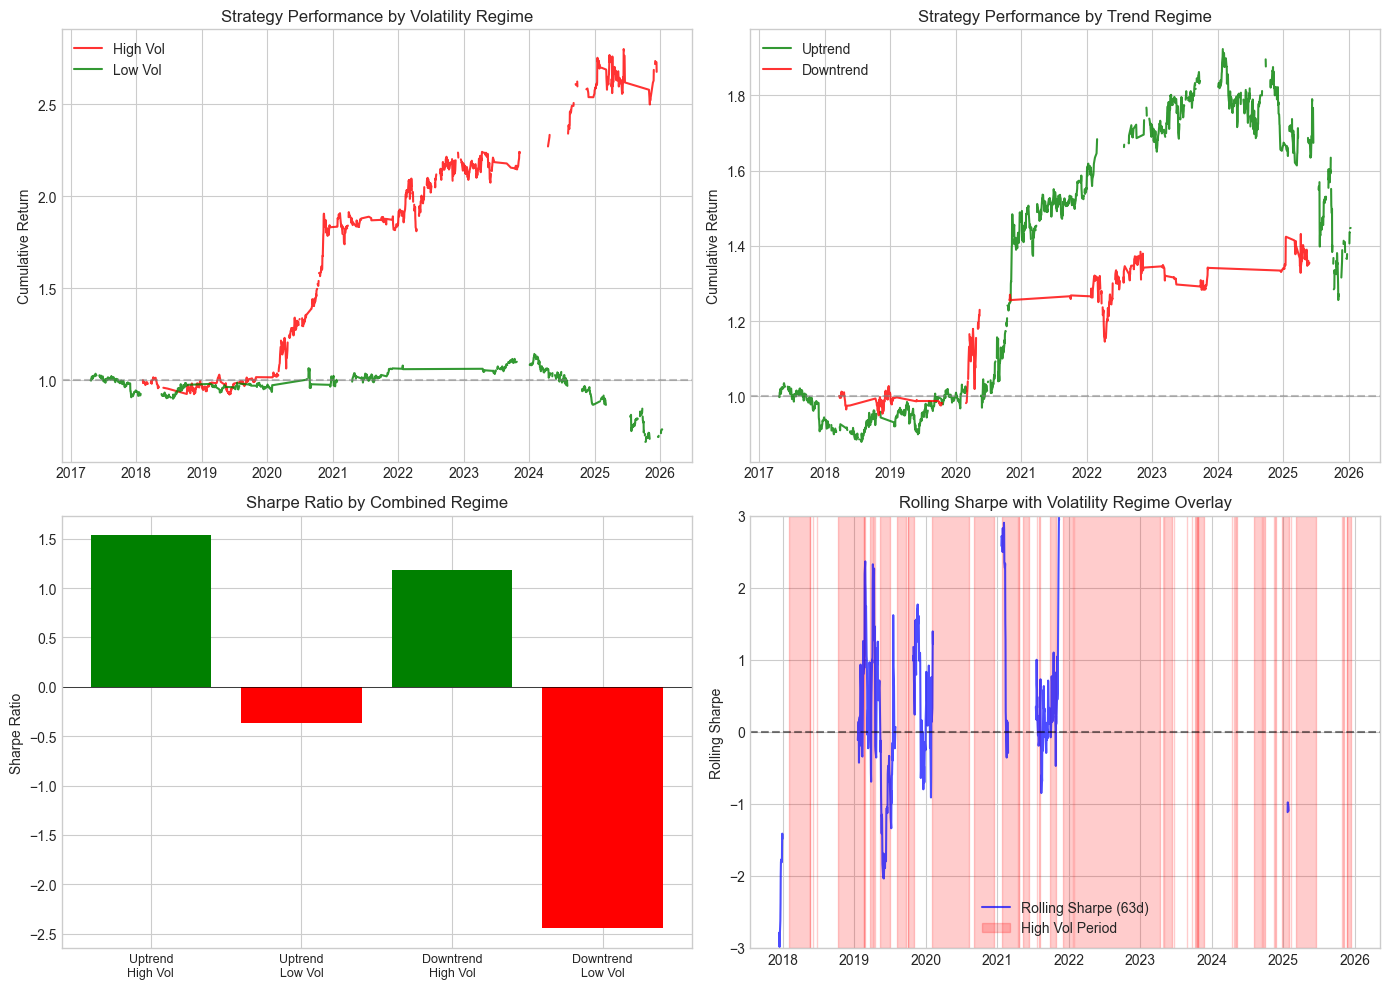

In [15]:
# Visualize regime performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns by volatility regime
ax = axes[0, 0]
for vol_state, label, color in [(True, 'High Vol', 'red'), (False, 'Low Vol', 'green')]:
    mask = vol_aligned == vol_state
    cum_ret = (1 + strat_aligned[mask]).cumprod()
    ax.plot(cum_ret.index, cum_ret.values, label=label, color=color, alpha=0.8)
ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy Performance by Volatility Regime')
ax.legend()

# 2. Cumulative returns by trend
ax = axes[0, 1]
for trend_state, label, color in [(True, 'Uptrend', 'green'), (False, 'Downtrend', 'red')]:
    mask = trend_aligned == trend_state
    cum_ret = (1 + strat_aligned[mask]).cumprod()
    ax.plot(cum_ret.index, cum_ret.values, label=label, color=color, alpha=0.8)
ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy Performance by Trend Regime')
ax.legend()

# 3. Sharpe by regime (bar chart)
ax = axes[1, 0]
regimes_list = list(regime_perf.keys())
sharpes = [regime_perf[r]['sharpe'] for r in regimes_list]
colors = ['green' if s > 0 else 'red' for s in sharpes]
ax.bar(range(len(regimes_list)), sharpes, color=colors)
ax.set_xticks(range(len(regimes_list)))
ax.set_xticklabels([r.replace(' + ', '\n') for r in regimes_list], fontsize=9)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio by Combined Regime')

# 4. Rolling regime over time with returns
ax = axes[1, 1]
rolling_sharpe = strat_aligned.rolling(63).mean() / strat_aligned.rolling(63).std() * np.sqrt(252)
ax.plot(rolling_sharpe.index, rolling_sharpe.values, 'b-', alpha=0.7, label='Rolling Sharpe (63d)')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)

# Shade high vol periods
ax.fill_between(vol_aligned.index, -3, 3, where=vol_aligned, alpha=0.2, color='red', label='High Vol Period')
ax.set_ylim(-3, 3)
ax.set_ylabel('Rolling Sharpe')
ax.set_title('Rolling Sharpe with Volatility Regime Overlay')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/regime_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

---

# Part 4: Turnover Reduction Strategies

The model has **0.68 Gross Sharpe** but **441x turnover** destroys net returns.  
Let's fix this with:

1. **Position smoothing** (exponential decay)
2. **Conviction threshold** (only trade strong signals)
3. **Holding period constraint** (min days to hold)

In [16]:
# =============================================================================
# TURNOVER REDUCTION: POSITION SMOOTHING
# =============================================================================

def backtest_with_turnover_control(
    features, returns, 
    train_window=252, 
    retrain_interval=21,
    position_decay=0.8,  # Smoothing factor (0=no smoothing, 1=full smoothing)
    conviction_threshold=0.0,  # Minimum |prediction| to trade
    transaction_cost=0.001
):
    """Backtest with turnover control mechanisms"""
    
    feature_names = list(features.keys())
    F = len(feature_names)
    
    # Prepare data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    common_assets = list(returns.columns)
    
    T = len(common_dates)
    N = len(common_assets)
    
    # Build arrays
    X_panel = np.zeros((T, N, F))
    for fi, fname in enumerate(feature_names):
        X_panel[:, :, fi] = features[fname].loc[common_dates, common_assets].values
    y_panel = returns.loc[common_dates, common_assets].values
    
    # Backtest with position smoothing
    daily_returns = []
    turnovers = []
    current_model = None
    prev_positions = None
    smoothed_positions = None
    
    for t in range(train_window, T):
        day_idx = t - train_window
        date = common_dates[t]
        
        # Retrain if needed
        if day_idx % retrain_interval == 0 or current_model is None:
            X_train = X_panel[t-train_window:t].reshape(-1, F)
            y_train = y_panel[t-train_window:t].flatten()
            valid = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
            
            current_model = lgb.LGBMRegressor(
                n_estimators=50, max_depth=3, learning_rate=0.1,
                min_child_samples=100, verbosity=-1, n_jobs=-1
            )
            current_model.fit(X_train[valid], y_train[valid])
        
        # Predict
        X_test = X_panel[t]
        valid_test = ~np.isnan(X_test).any(axis=1)
        raw_pred = current_model.predict(X_test)
        raw_pred[~valid_test] = 0
        
        # Apply conviction threshold
        pred = np.where(np.abs(raw_pred) > conviction_threshold, raw_pred, 0)
        
        # Convert to target positions (cross-sectional rank)
        pred_series = pd.Series(pred, index=common_assets)
        pred_clean = pred_series[pred_series != 0]
        
        if len(pred_clean) < 10:
            continue
        
        n_long = max(1, int(len(pred_clean) * 0.2))
        ranks = pred_clean.rank(ascending=False)
        long_mask = ranks <= n_long
        short_mask = ranks > len(pred_clean) - n_long
        
        target_positions = pd.Series(0.0, index=common_assets)
        target_positions[pred_clean[long_mask].index] = 1.0 / n_long
        target_positions[pred_clean[short_mask].index] = -1.0 / n_long
        
        # Apply position smoothing (exponential moving average)
        if smoothed_positions is None:
            smoothed_positions = target_positions.copy()
        else:
            smoothed_positions = position_decay * smoothed_positions + (1 - position_decay) * target_positions
        
        # Normalize to dollar-neutral
        long_sum = smoothed_positions[smoothed_positions > 0].sum()
        short_sum = abs(smoothed_positions[smoothed_positions < 0].sum())
        if long_sum > 0:
            smoothed_positions[smoothed_positions > 0] /= long_sum
        if short_sum > 0:
            smoothed_positions[smoothed_positions < 0] /= short_sum
        
        # Calculate return
        actual_ret = returns.loc[date, common_assets]
        port_ret = (smoothed_positions * actual_ret).sum()
        
        # Calculate turnover
        if prev_positions is not None:
            turnover = np.abs(smoothed_positions - prev_positions).sum()
            turnovers.append(turnover)
        
        daily_returns.append({'date': date, 'return': port_ret})
        prev_positions = smoothed_positions.copy()
    
    # Calculate metrics
    ret_series = pd.DataFrame(daily_returns).set_index('date')['return']
    avg_turnover = np.mean(turnovers) * 252 if turnovers else 0
    
    gross_sharpe = ret_series.mean() / ret_series.std() * np.sqrt(252) if ret_series.std() > 0 else 0
    net_returns = ret_series - avg_turnover / 252 * transaction_cost
    net_sharpe = net_returns.mean() / net_returns.std() * np.sqrt(252) if net_returns.std() > 0 else 0
    
    cum_ret = (1 + ret_series).cumprod()
    total_ret = cum_ret.iloc[-1] - 1
    max_dd = (cum_ret / cum_ret.cummax() - 1).min()
    
    return {
        'returns': ret_series,
        'gross_sharpe': gross_sharpe,
        'net_sharpe': net_sharpe,
        'total_return': total_ret,
        'turnover': avg_turnover,
        'max_drawdown': max_dd
    }

print("✅ Turnover-controlled backtest function ready")

✅ Turnover-controlled backtest function ready


In [17]:
# =============================================================================
# TEST DIFFERENT TURNOVER REDUCTION SETTINGS
# =============================================================================

print("Testing turnover reduction strategies...")
print("=" * 70)

# Test different decay values
decay_results = {}

for decay in [0.0, 0.5, 0.7, 0.8, 0.9, 0.95]:
    print(f"\n   Testing decay={decay}...")
    result = backtest_with_turnover_control(
        features, returns,
        train_window=252,
        retrain_interval=21,
        position_decay=decay,
        conviction_threshold=0.0,
        transaction_cost=0.001
    )
    decay_results[decay] = result
    print(f"      Gross Sharpe: {result['gross_sharpe']:.3f}, Net Sharpe: {result['net_sharpe']:.3f}, Turnover: {result['turnover']:.0f}x")

print("\n" + "=" * 70)
print("📊 TURNOVER REDUCTION RESULTS")
print("=" * 70)
print(f"{'Decay':>8} | {'Gross Sharpe':>12} | {'Net Sharpe':>12} | {'Turnover':>10} | {'Return':>10}")
print("-" * 70)
for decay, result in decay_results.items():
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"{decay:>8.2f} | {result['gross_sharpe']:>12.3f} | {result['net_sharpe']:>12.3f} {net_status} | {result['turnover']:>10.0f}x | {result['total_return']*100:>9.1f}%")

Testing turnover reduction strategies...

   Testing decay=0.0...
      Gross Sharpe: 0.622, Net Sharpe: -2.255, Turnover: 561x

   Testing decay=0.5...
      Gross Sharpe: 0.646, Net Sharpe: -1.240, Turnover: 253x

   Testing decay=0.7...
      Gross Sharpe: 0.647, Net Sharpe: -0.566, Turnover: 154x

   Testing decay=0.8...
      Gross Sharpe: 0.643, Net Sharpe: -0.185, Turnover: 103x

   Testing decay=0.9...
      Gross Sharpe: 0.679, Net Sharpe: 0.268, Turnover: 51x

   Testing decay=0.95...
      Gross Sharpe: 0.590, Net Sharpe: 0.386, Turnover: 25x

📊 TURNOVER REDUCTION RESULTS
   Decay | Gross Sharpe |   Net Sharpe |   Turnover |     Return
----------------------------------------------------------------------
    0.00 |        0.622 |       -2.255 ❌ |        561x |     144.1%
    0.50 |        0.646 |       -1.240 ❌ |        253x |      97.0%
    0.70 |        0.647 |       -0.566 ❌ |        154x |      90.9%
    0.80 |        0.643 |       -0.185 ❌ |        103x |      88.2%
  

In [2]:
# Visualize turnover vs performance tradeoff
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

decays = list(decay_results.keys())
turnovers = [decay_results[d]['turnover'] for d in decays]
gross_sharpes = [decay_results[d]['gross_sharpe'] for d in decays]
net_sharpes = [decay_results[d]['net_sharpe'] for d in decays]
returns_pct = [decay_results[d]['total_return'] * 100 for d in decays]

# 1. Turnover reduction
ax = axes[0]
ax.plot(decays, turnovers, 'b-o', linewidth=2, markersize=10)
ax.set_xlabel('Position Decay Factor')
ax.set_ylabel('Annual Turnover (x)')
ax.set_title('Turnover vs Position Smoothing')
ax.grid(True, alpha=0.3)

# 2. Sharpe comparison
ax = axes[1]
ax.plot(decays, gross_sharpes, 'g-o', linewidth=2, markersize=10, label='Gross Sharpe')
ax.plot(decays, net_sharpes, 'r-s', linewidth=2, markersize=10, label='Net Sharpe')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Position Decay Factor')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio vs Position Smoothing')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Net Sharpe vs Turnover (the key tradeoff)
ax = axes[2]
scatter = ax.scatter(turnovers, net_sharpes, c=decays, cmap='viridis', s=200, edgecolors='black')
for i, decay in enumerate(decays):
    ax.annotate(f'{decay}', (turnovers[i], net_sharpes[i]), textcoords="offset points", xytext=(5,5))
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax.set_xlabel('Annual Turnover (x)')
ax.set_ylabel('Net Sharpe Ratio')
ax.set_title('Net Sharpe vs Turnover Tradeoff')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Decay Factor')

plt.tight_layout()
plt.savefig('../outputs/turnover_reduction.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best decay
best_decay = max(decay_results.keys(), key=lambda d: decay_results[d]['net_sharpe'])
print(f"\n🏆 Best decay factor: {best_decay} with Net Sharpe = {decay_results[best_decay]['net_sharpe']:.3f}")

NameError: name 'plt' is not defined

---

# Part 5: Reliability-Weighted Alpha Pipeline

A different approach: Convert predictions to **classification** (up/down/hold) and weight by historical **hit rate**.

In [28]:
# =============================================================================
# RELIABILITY-WEIGHTED ALPHA PIPELINE (with LightGBM + Decay)
# =============================================================================

def reliability_weighted_backtest(
    features, returns,
    train_window=252,
    retrain_interval=21,
    calibration_window=63,  # Window for hit-rate calculation
    epsilon_quantile=0.3,   # Top/bottom 30% classified as up/down
    position_decay=0.0,     # Position smoothing (0=none, 0.9=heavy)
    use_lgb=True,           # Use LightGBM instead of LogReg
    transaction_cost=0.001
):
    """
    Reliability-Weighted Cross-Sectional Alpha Construction
    
    Features Used (12 total):
    - Baseline: ret_1d, ret_5d, vol_20d
    - Momentum: mom_3d, mom_5d, mom_10d  
    - Trend Regime: trend_strength, trend_consistency, trend_breadth
    - Interactions: mom_5d_x_trend, mom_5d_x_consistency, mom_5d_x_breadth
    
    Pipeline:
    1. Convert returns to labels (up/down/hold) using epsilon threshold
    2. Train classifier (LightGBM or LogReg) to predict probabilities
    3. Compute directional score: s = P(up) - P(down)
    4. Weight signals by per-asset hit rate: r = hit_rate * s
    5. Cross-sectionally center for dollar neutrality: alpha = r - mean(r)
    6. Apply position decay for turnover control
    """
    from sklearn.linear_model import LogisticRegression
    
    feature_names = list(features.keys())
    F = len(feature_names)
    
    print(f"📊 Features being used ({F} total):")
    for fname in feature_names:
        print(f"   • {fname}")
    print(f"\n🔧 Model: {'LightGBM Classifier' if use_lgb else 'Logistic Regression'}")
    print(f"🔧 Position Decay: {position_decay}")
    
    # Prepare data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    common_assets = list(returns.columns)
    
    T = len(common_dates)
    N = len(common_assets)
    
    # Build arrays
    X_panel = np.zeros((T, N, F))
    for fi, fname in enumerate(feature_names):
        X_panel[:, :, fi] = features[fname].loc[common_dates, common_assets].values
    y_panel = returns.loc[common_dates, common_assets].values
    
    # Track predictions for hit-rate calculation
    pred_history = {asset: [] for asset in common_assets}  # List of (pred_class, true_class)
    hit_rates = {asset: 0.5 for asset in common_assets}  # Initialize at 50%
    
    daily_returns = []
    turnovers = []
    current_model = None
    prev_positions = None
    smoothed_positions = None
    
    print(f"\nRunning reliability-weighted backtest...")
    
    for t in range(train_window, T):
        day_idx = t - train_window
        date = common_dates[t]
        
        # Compute epsilon threshold from training window
        train_returns = y_panel[t-train_window:t].flatten()
        train_returns = train_returns[~np.isnan(train_returns)]
        epsilon = np.quantile(np.abs(train_returns), epsilon_quantile)
        
        # Convert to labels: -1 (down), 0 (hold), 1 (up)
        def to_labels(r, eps):
            labels = np.zeros_like(r, dtype=int)
            labels[r > eps] = 1
            labels[r < -eps] = -1
            return labels
        
        # Retrain classifier if needed
        if day_idx % retrain_interval == 0 or current_model is None:
            X_train = X_panel[t-train_window:t].reshape(-1, F)
            y_train_raw = y_panel[t-train_window:t].flatten()
            
            valid = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train_raw))
            X_train = X_train[valid]
            y_train_labels = to_labels(y_train_raw[valid], epsilon)
            
            # Ensure all classes present
            unique_labels = np.unique(y_train_labels)
            if len(unique_labels) < 2:
                continue
            
            if use_lgb:
                # LightGBM Classifier (non-linear, captures interactions)
                current_model = lgb.LGBMClassifier(
                    n_estimators=50,
                    max_depth=3,
                    learning_rate=0.1,
                    min_child_samples=100,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    verbosity=-1,
                    n_jobs=-1
                )
            else:
                # Logistic Regression (linear baseline)
                current_model = LogisticRegression(
                    solver='lbfgs',
                    max_iter=500,
                    C=1.0
                )
            
            current_model.fit(X_train, y_train_labels)
        
        # Predict probabilities
        X_test = X_panel[t]
        valid_test = ~np.isnan(X_test).any(axis=1)
        
        if current_model is None:
            continue
        
        try:
            probs = current_model.predict_proba(X_test)
            classes = list(current_model.classes_)
            
            # Get probabilities for each class
            p_up = probs[:, classes.index(1)] if 1 in classes else np.zeros(N)
            p_down = probs[:, classes.index(-1)] if -1 in classes else np.zeros(N)
            
            # Predicted class
            pred_class = current_model.predict(X_test)
        except:
            continue
        
        # Actual labels for hit-rate update
        actual_returns = y_panel[t]
        actual_labels = to_labels(actual_returns, epsilon)
        
        # Update prediction history and hit rates
        for i, asset in enumerate(common_assets):
            if valid_test[i] and not np.isnan(actual_returns[i]):
                pred_history[asset].append((pred_class[i], actual_labels[i]))
                # Keep only last calibration_window predictions
                if len(pred_history[asset]) > calibration_window:
                    pred_history[asset] = pred_history[asset][-calibration_window:]
                # Calculate hit rate
                if len(pred_history[asset]) >= 10:
                    hits = sum(1 for p, a in pred_history[asset] if p == a)
                    hit_rates[asset] = hits / len(pred_history[asset])
        
        # Compute raw directional score: s = p_up - p_down
        raw_score = p_up - p_down
        
        # Apply reliability weighting: r = h * s
        reliability_weights = np.array([hit_rates[asset] for asset in common_assets])
        weighted_score = reliability_weights * raw_score
        weighted_score[~valid_test] = 0
        
        # Cross-sectionally center for dollar neutrality: alpha = r - mean(r)
        valid_scores = weighted_score[valid_test]
        if len(valid_scores) > 0:
            alpha = weighted_score - np.mean(valid_scores)
        else:
            continue
        
        # Convert alpha to target positions (normalized)
        target_positions = pd.Series(alpha, index=common_assets)
        target_positions[~valid_test] = 0
        
        # Normalize long/short sides
        long_sum = target_positions[target_positions > 0].sum()
        short_sum = abs(target_positions[target_positions < 0].sum())
        if long_sum > 0:
            target_positions[target_positions > 0] /= long_sum
        if short_sum > 0:
            target_positions[target_positions < 0] /= short_sum
        
        # Apply position decay (smoothing)
        if position_decay > 0:
            if smoothed_positions is None:
                smoothed_positions = target_positions.copy()
            else:
                smoothed_positions = position_decay * smoothed_positions + (1 - position_decay) * target_positions
            
            # Re-normalize after smoothing
            long_sum = smoothed_positions[smoothed_positions > 0].sum()
            short_sum = abs(smoothed_positions[smoothed_positions < 0].sum())
            if long_sum > 0:
                smoothed_positions[smoothed_positions > 0] /= long_sum
            if short_sum > 0:
                smoothed_positions[smoothed_positions < 0] /= short_sum
            
            positions = smoothed_positions
        else:
            positions = target_positions
        
        # Calculate return
        actual_ret = returns.loc[date, common_assets]
        port_ret = (positions * actual_ret).sum()
        
        # Calculate turnover
        if prev_positions is not None:
            turnover = np.abs(positions - prev_positions).sum()
            turnovers.append(turnover)
        
        daily_returns.append({'date': date, 'return': port_ret})
        prev_positions = positions.copy()
        
        if (day_idx + 1) % 500 == 0:
            print(f"   Day {day_idx + 1}/{T - train_window}")
    
    # Calculate metrics
    ret_series = pd.DataFrame(daily_returns).set_index('date')['return']
    avg_turnover = np.mean(turnovers) * 252 if turnovers else 0
    
    gross_sharpe = ret_series.mean() / ret_series.std() * np.sqrt(252) if ret_series.std() > 0 else 0
    net_returns = ret_series - avg_turnover / 252 * transaction_cost
    net_sharpe = net_returns.mean() / net_returns.std() * np.sqrt(252) if net_returns.std() > 0 else 0
    
    cum_ret = (1 + ret_series).cumprod()
    total_ret = cum_ret.iloc[-1] - 1
    max_dd = (cum_ret / cum_ret.cummax() - 1).min()
    
    return {
        'returns': ret_series,
        'gross_sharpe': gross_sharpe,
        'net_sharpe': net_sharpe,
        'total_return': total_ret,
        'turnover': avg_turnover,
        'max_drawdown': max_dd,
        'hit_rates': hit_rates
    }

print("✅ Reliability-weighted backtest function ready (LightGBM + Decay)")
print("   Features: 12 regime-conditioned momentum features")
print("   Model options: LightGBM Classifier (default) or Logistic Regression")
print("   Turnover control: Position decay parameter")

✅ Reliability-weighted backtest function ready (LightGBM + Decay)
   Features: 12 regime-conditioned momentum features
   Model options: LightGBM Classifier (default) or Logistic Regression
   Turnover control: Position decay parameter


In [27]:
# =============================================================================
# TEST RELIABILITY-WEIGHTED PIPELINE: Different Configs
# =============================================================================

print("=" * 70)
print("🎯 RELIABILITY-WEIGHTED ALPHA: Model & Decay Comparison")
print("=" * 70)

rw_results = {}

# Test configurations: (use_lgb, position_decay, label)
configs = [
    (False, 0.0, "LogReg (no decay)"),
    (False, 0.8, "LogReg (decay=0.8)"),
    (True, 0.0, "LightGBM (no decay)"),
    (True, 0.5, "LightGBM (decay=0.5)"),
    (True, 0.8, "LightGBM (decay=0.8)"),
    (True, 0.9, "LightGBM (decay=0.9)"),
]

for use_lgb, decay, label in configs:
    print(f"\n{'='*50}")
    print(f"Testing: {label}")
    print(f"{'='*50}")
    
    result = reliability_weighted_backtest(
        features, returns,
        train_window=252,
        retrain_interval=21,
        calibration_window=63,
        epsilon_quantile=0.3,
        position_decay=decay,
        use_lgb=use_lgb,
        transaction_cost=0.001
    )
    rw_results[label] = result
    
    print(f"\n📊 Results for {label}:")
    print(f"   Gross Sharpe: {result['gross_sharpe']:.4f}")
    print(f"   Net Sharpe:   {result['net_sharpe']:.4f}")
    print(f"   Total Return: {result['total_return']*100:.2f}%")
    print(f"   Turnover:     {result['turnover']:.1f}x")

# Summary table
print("\n" + "=" * 80)
print("📊 RELIABILITY-WEIGHTED ALPHA: SUMMARY")
print("=" * 80)
print(f"\n{'Configuration':30s} | {'Gross':>8} | {'Net':>8} | {'Turnover':>10} | {'Return':>10}")
print("-" * 80)
for label, result in rw_results.items():
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"{label:30s} | {result['gross_sharpe']:>8.3f} | {result['net_sharpe']:>8.3f}{net_status} | {result['turnover']:>10.0f}x | {result['total_return']*100:>9.1f}%")

🎯 RELIABILITY-WEIGHTED ALPHA: Model & Decay Comparison

Testing: LogReg (no decay)
📊 Features being used (12 total):
   • ret_1d
   • ret_5d
   • vol_20d
   • mom_3d
   • mom_5d
   • mom_10d
   • trend_strength
   • trend_consistency
   • trend_breadth
   • mom_5d_x_trend
   • mom_5d_x_consistency
   • mom_5d_x_breadth

🔧 Model: Logistic Regression
🔧 Position Decay: 0.0

Running reliability-weighted backtest...
   Day 500/2198
   Day 1000/2198
   Day 1500/2198
   Day 2000/2198

📊 Results for LogReg (no decay):
   Gross Sharpe: 1.6276
   Net Sharpe:   -0.7414
   Total Return: 767.65%
   Turnover:     379.3x

Testing: LogReg (decay=0.8)
📊 Features being used (12 total):
   • ret_1d
   • ret_5d
   • vol_20d
   • mom_3d
   • mom_5d
   • mom_10d
   • trend_strength
   • trend_consistency
   • trend_breadth
   • mom_5d_x_trend
   • mom_5d_x_consistency
   • mom_5d_x_breadth

🔧 Model: Logistic Regression
🔧 Position Decay: 0.8

Running reliability-weighted backtest...
   Day 500/2198
   Day 10

In [29]:
# Compare all approaches
print("\n" + "=" * 70)
print("📊 COMPARISON: ALL APPROACHES")
print("=" * 70)

# Get best decay result
best_decay = max(decay_results.keys(), key=lambda d: decay_results[d]['net_sharpe'])
best_smooth = decay_results[best_decay]

comparison = {
    'LGB (No Control)': decay_results[0.0],
    f'LGB (Decay={best_decay})': best_smooth,
    'Reliability-Weighted': rw_result
}

print(f"\n{'Approach':30s} | {'Gross':>8} | {'Net':>8} | {'Turnover':>10} | {'Return':>10}")
print("-" * 80)
for name, result in comparison.items():
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"{name:30s} | {result['gross_sharpe']:>8.3f} | {result['net_sharpe']:>8.3f}{net_status} | {result['turnover']:>10.0f}x | {result['total_return']*100:>9.1f}%")


📊 COMPARISON: ALL APPROACHES

Approach                       |    Gross |      Net |   Turnover |     Return
--------------------------------------------------------------------------------
LGB (No Control)               |    0.622 |   -2.255❌ |        561x |     144.1%
LGB (Decay=0.95)               |    0.590 |    0.386✅ |         25x |      75.9%
Reliability-Weighted           |    1.628 |   -0.741❌ |        379x |     767.6%


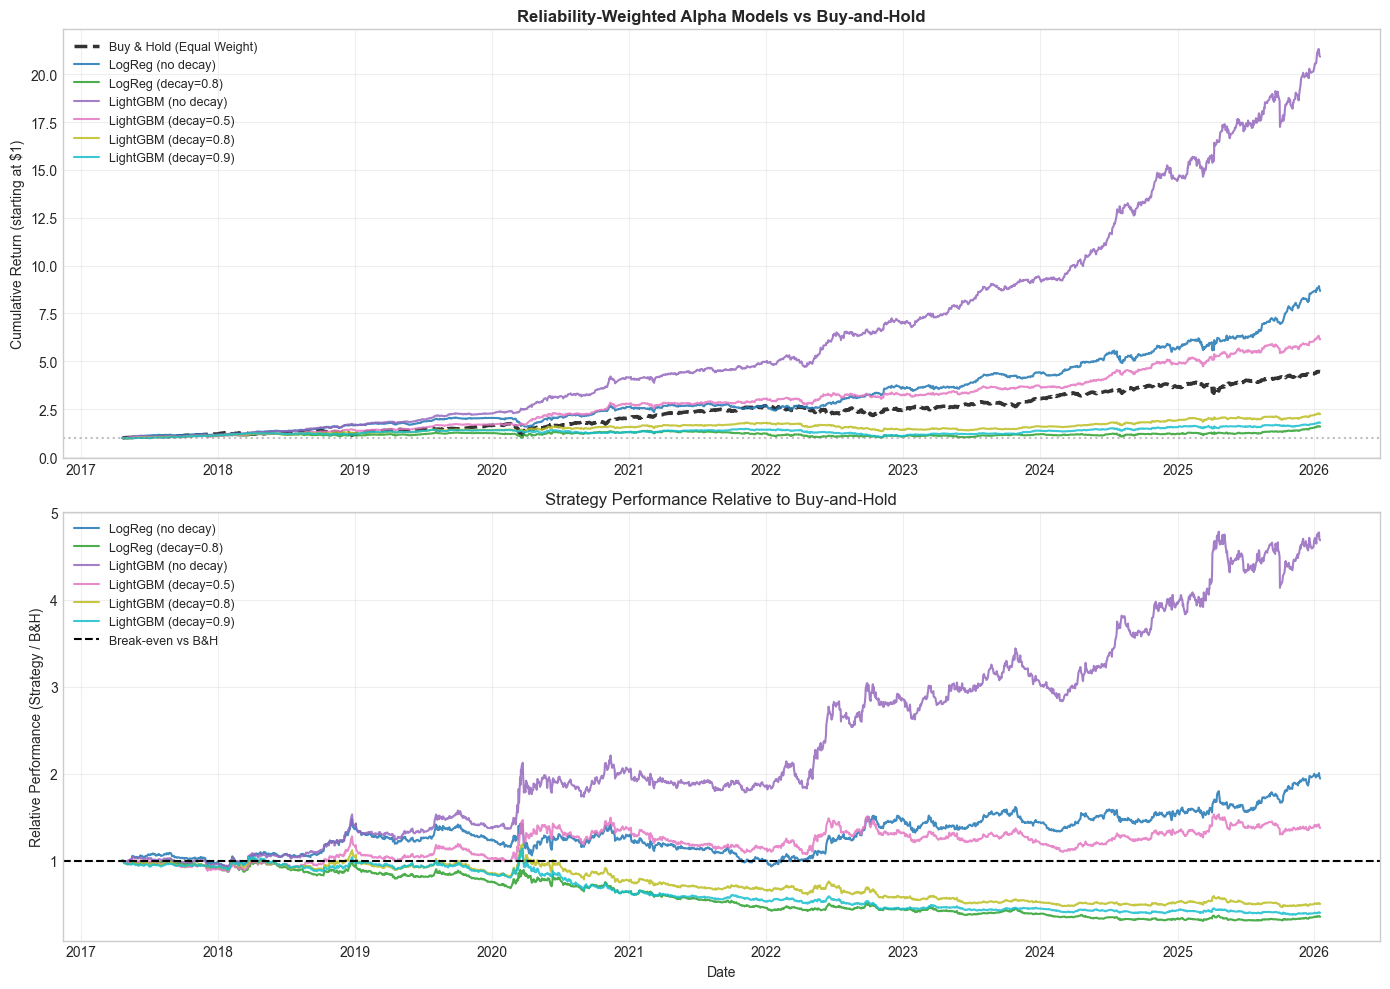


📊 Final Cumulative Returns:
   Buy & Hold:  4.466x (+346.6%)
   LogReg (no decay)             : 8.676x (+767.6%)
   LogReg (decay=0.8)            : 1.590x (+59.0%)
   LightGBM (no decay)           : 20.912x (+1991.2%)
   LightGBM (decay=0.5)          : 6.149x (+514.9%)
   LightGBM (decay=0.8)          : 2.243x (+124.3%)
   LightGBM (decay=0.9)          : 1.792x (+79.2%)


In [30]:
# =============================================================================
# VISUALIZATION: All Models vs Buy-and-Hold
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Cumulative Returns Plot ---
ax = axes[0]

# Buy-and-hold benchmark (equal-weight market)
market_ret = returns.mean(axis=1)
# Align to same date range as strategy returns
first_date = min(rw_results[k]['returns'].index[0] for k in rw_results)
last_date = max(rw_results[k]['returns'].index[-1] for k in rw_results)
market_aligned = market_ret.loc[first_date:last_date]
bh_cumret = (1 + market_aligned).cumprod()
ax.plot(bh_cumret.index, bh_cumret.values, 'k--', linewidth=2.5, label='Buy & Hold (Equal Weight)', alpha=0.8)

# Plot all model returns
colors = plt.cm.tab10(np.linspace(0, 1, len(rw_results)))
for (label, result), color in zip(rw_results.items(), colors):
    cum_ret = (1 + result['returns']).cumprod()
    ax.plot(cum_ret.index, cum_ret.values, linewidth=1.5, label=label, color=color, alpha=0.85)

ax.axhline(1, color='gray', linestyle=':', alpha=0.5)
ax.set_ylabel('Cumulative Return (starting at $1)')
ax.set_title('Reliability-Weighted Alpha Models vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# --- Relative Performance vs Benchmark ---
ax = axes[1]

for (label, result), color in zip(rw_results.items(), colors):
    # Align dates
    common_dates = result['returns'].index.intersection(market_aligned.index)
    strat = result['returns'].loc[common_dates]
    mkt = market_aligned.loc[common_dates]
    
    # Relative cumulative (strategy / benchmark)
    strat_cum = (1 + strat).cumprod()
    mkt_cum = (1 + mkt).cumprod()
    relative = strat_cum / mkt_cum
    
    ax.plot(relative.index, relative.values, linewidth=1.5, label=label, color=color, alpha=0.85)

ax.axhline(1, color='black', linestyle='--', linewidth=1.5, label='Break-even vs B&H')
ax.set_ylabel('Relative Performance (Strategy / B&H)')
ax.set_xlabel('Date')
ax.set_title('Strategy Performance Relative to Buy-and-Hold', fontsize=12)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/rw_models_vs_buyhold.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final cumulative returns
print("\n📊 Final Cumulative Returns:")
print(f"   Buy & Hold:  {bh_cumret.iloc[-1]:.3f}x ({(bh_cumret.iloc[-1]-1)*100:+.1f}%)")
for label, result in rw_results.items():
    final = (1 + result['returns']).cumprod().iloc[-1]
    print(f"   {label:30s}: {final:.3f}x ({(final-1)*100:+.1f}%)")

---

# Part 6: Advanced Execution Rules

## Turnover Reduction Techniques

1. **Rank Hysteresis** - Only trade when rank change exceeds threshold or signal persists k days
2. **Volatility-Scaled Decay** - Increase position decay in high-vol regimes (signals are noisier)
3. **Training Window Optimization** - Test shorter windows (50, 100, 150, 200, 252)

In [35]:
# =============================================================================
# ADVANCED EXECUTION RULES: Rank Hysteresis + Vol-Scaled Decay
# =============================================================================

def advanced_reliability_backtest(
    features, returns,
    train_window=252,
    retrain_interval=21,
    calibration_window=63,
    epsilon_quantile=0.3,
    # --- RANK HYSTERESIS ---
    rank_persistence_days=2,      # Require signal to persist k days before trading
    entry_quantile=0.2,           # Enter only if in top/bottom 20%
    exit_quantile=0.4,            # Exit only if rank drops below top/bottom 40%
    # --- VOL-SCALED DECAY ---
    base_decay=0.5,               # Base position decay
    high_vol_decay=0.8,           # Decay during high volatility
    vol_lookback=20,              # Window for vol calculation
    # --- OTHER ---
    transaction_cost=0.001
):
    """
    Advanced Reliability-Weighted Alpha with Execution Rules:
    
    1. RANK HYSTERESIS:
       - Track consecutive days each asset stays in top/bottom quintile
       - Only ENTER position if signal persists for k days
       - Only EXIT if rank drops significantly (not just below threshold)
       
    2. VOL-SCALED DECAY:
       - When 20d realized vol > median, use high_vol_decay
       - When vol is low, use base_decay
       - This reduces churn in noisy periods
    """
    
    feature_names = list(features.keys())
    F = len(feature_names)
    
    # Prepare data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    common_assets = list(returns.columns)
    
    T = len(common_dates)
    N = len(common_assets)
    
    # Build arrays
    X_panel = np.zeros((T, N, F))
    for fi, fname in enumerate(feature_names):
        X_panel[:, :, fi] = features[fname].loc[common_dates, common_assets].values
    y_panel = returns.loc[common_dates, common_assets].values
    
    # Pre-compute market volatility for vol-scaling
    market_ret = returns.loc[common_dates].mean(axis=1)
    market_vol = market_ret.rolling(vol_lookback).std() * np.sqrt(252)
    vol_median = market_vol.median()
    
    # Track state
    pred_history = {asset: [] for asset in common_assets}
    hit_rates = {asset: 0.5 for asset in common_assets}
    
    # Rank persistence tracking: how many consecutive days in top/bottom quintile
    days_in_long = {asset: 0 for asset in common_assets}
    days_in_short = {asset: 0 for asset in common_assets}
    
    daily_returns = []
    turnovers = []
    current_model = None
    prev_positions = None
    smoothed_positions = None
    
    # Track current positions for hysteresis
    current_long = set()
    current_short = set()
    
    for t in range(train_window, T):
        day_idx = t - train_window
        date = common_dates[t]
        
        # --- VOL-SCALED DECAY ---
        current_vol = market_vol.iloc[t] if t < len(market_vol) else vol_median
        if pd.isna(current_vol):
            current_vol = vol_median
        decay = high_vol_decay if current_vol > vol_median else base_decay
        
        # Compute epsilon threshold
        train_returns = y_panel[t-train_window:t].flatten()
        train_returns = train_returns[~np.isnan(train_returns)]
        epsilon = np.quantile(np.abs(train_returns), epsilon_quantile)
        
        def to_labels(r, eps):
            labels = np.zeros_like(r, dtype=int)
            labels[r > eps] = 1
            labels[r < -eps] = -1
            return labels
        
        # Retrain classifier if needed
        if day_idx % retrain_interval == 0 or current_model is None:
            X_train = X_panel[t-train_window:t].reshape(-1, F)
            y_train_raw = y_panel[t-train_window:t].flatten()
            
            valid = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train_raw))
            X_train = X_train[valid]
            y_train_labels = to_labels(y_train_raw[valid], epsilon)
            
            if len(np.unique(y_train_labels)) < 2:
                continue
            
            current_model = lgb.LGBMClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.1,
                min_child_samples=100, verbosity=-1, n_jobs=-1
            )
            current_model.fit(X_train, y_train_labels)
        
        # Predict
        X_test = X_panel[t]
        valid_test = ~np.isnan(X_test).any(axis=1)
        
        if current_model is None:
            continue
        
        try:
            probs = current_model.predict_proba(X_test)
            classes = list(current_model.classes_)
            p_up = probs[:, classes.index(1)] if 1 in classes else np.zeros(N)
            p_down = probs[:, classes.index(-1)] if -1 in classes else np.zeros(N)
            pred_class = current_model.predict(X_test)
        except:
            continue
        
        # Update hit rates
        actual_returns = y_panel[t]
        actual_labels = to_labels(actual_returns, epsilon)
        for i, asset in enumerate(common_assets):
            if valid_test[i] and not np.isnan(actual_returns[i]):
                pred_history[asset].append((pred_class[i], actual_labels[i]))
                if len(pred_history[asset]) > calibration_window:
                    pred_history[asset] = pred_history[asset][-calibration_window:]
                if len(pred_history[asset]) >= 10:
                    hits = sum(1 for p, a in pred_history[asset] if p == a)
                    hit_rates[asset] = hits / len(pred_history[asset])
        
        # Compute directional score
        raw_score = p_up - p_down
        reliability_weights = np.array([hit_rates[asset] for asset in common_assets])
        weighted_score = reliability_weights * raw_score
        weighted_score[~valid_test] = np.nan
        
        # --- RANK HYSTERESIS ---
        score_series = pd.Series(weighted_score, index=common_assets).dropna()
        if len(score_series) < 10:
            continue
        
        ranks = score_series.rank(pct=True)  # Percentile rank (0 to 1)
        n_assets = len(score_series)
        
        # Update persistence counters
        for asset in common_assets:
            if asset not in ranks.index:
                days_in_long[asset] = 0
                days_in_short[asset] = 0
                continue
            
            rank_pct = ranks[asset]
            
            # In top quintile?
            if rank_pct >= (1 - entry_quantile):
                days_in_long[asset] += 1
                days_in_short[asset] = 0
            # In bottom quintile?
            elif rank_pct <= entry_quantile:
                days_in_short[asset] += 1
                days_in_long[asset] = 0
            else:
                # Reset if in middle
                days_in_long[asset] = max(0, days_in_long[asset] - 1)
                days_in_short[asset] = max(0, days_in_short[asset] - 1)
        
        # Determine target positions with hysteresis
        target_positions = pd.Series(0.0, index=common_assets)
        new_long = set()
        new_short = set()
        
        for asset in score_series.index:
            rank_pct = ranks[asset]
            
            # ENTRY LOGIC: Only enter if signal persisted
            if days_in_long[asset] >= rank_persistence_days:
                new_long.add(asset)
            elif days_in_short[asset] >= rank_persistence_days:
                new_short.add(asset)
            
            # HOLD LOGIC: Keep existing position unless exit threshold hit
            elif asset in current_long:
                # Exit only if dropped below exit threshold
                if rank_pct >= (1 - exit_quantile):
                    new_long.add(asset)  # Keep holding
            elif asset in current_short:
                if rank_pct <= exit_quantile:
                    new_short.add(asset)  # Keep holding
        
        # Set positions
        if len(new_long) > 0:
            for asset in new_long:
                target_positions[asset] = 1.0 / len(new_long)
        if len(new_short) > 0:
            for asset in new_short:
                target_positions[asset] = -1.0 / len(new_short)
        
        current_long = new_long
        current_short = new_short
        
        # Apply vol-scaled decay (smoothing)
        if smoothed_positions is None:
            smoothed_positions = target_positions.copy()
        else:
            smoothed_positions = decay * smoothed_positions + (1 - decay) * target_positions
        
        # Re-normalize
        long_sum = smoothed_positions[smoothed_positions > 0].sum()
        short_sum = abs(smoothed_positions[smoothed_positions < 0].sum())
        if long_sum > 0:
            smoothed_positions[smoothed_positions > 0] /= long_sum
        if short_sum > 0:
            smoothed_positions[smoothed_positions < 0] /= short_sum
        
        positions = smoothed_positions
        
        # Calculate return
        actual_ret = returns.loc[date, common_assets]
        port_ret = (positions * actual_ret).sum()
        
        # Calculate turnover
        if prev_positions is not None:
            turnover = np.abs(positions - prev_positions).sum()
            turnovers.append(turnover)
        
        daily_returns.append({'date': date, 'return': port_ret})
        prev_positions = positions.copy()
        
        if (day_idx + 1) % 500 == 0:
            print(f"   Day {day_idx + 1}/{T - train_window}")
    
    # Calculate metrics
    ret_series = pd.DataFrame(daily_returns).set_index('date')['return']
    avg_turnover = np.mean(turnovers) * 252 if turnovers else 0
    
    gross_sharpe = ret_series.mean() / ret_series.std() * np.sqrt(252) if ret_series.std() > 0 else 0
    net_returns = ret_series - avg_turnover / 252 * transaction_cost
    net_sharpe = net_returns.mean() / net_returns.std() * np.sqrt(252) if net_returns.std() > 0 else 0
    
    cum_ret = (1 + ret_series).cumprod()
    total_ret = cum_ret.iloc[-1] - 1
    max_dd = (cum_ret / cum_ret.cummax() - 1).min()
    
    return {
        'returns': ret_series,
        'gross_sharpe': gross_sharpe,
        'net_sharpe': net_sharpe,
        'total_return': total_ret,
        'turnover': avg_turnover,
        'max_drawdown': max_dd
    }

print("✅ Advanced backtest ready with:")
print("   • Rank Hysteresis (persistence + exit thresholds)")
print("   • Volatility-Scaled Decay (adaptive smoothing)")
print("   • Training window as parameter")

✅ Advanced backtest ready with:
   • Rank Hysteresis (persistence + exit thresholds)
   • Volatility-Scaled Decay (adaptive smoothing)
   • Training window as parameter


In [32]:
# =============================================================================
# TEST: Vary Training Window with Advanced Execution Rules
# =============================================================================

print("=" * 70)
print("🎯 TESTING: Training Windows + Rank Hysteresis + Vol-Scaled Decay")
print("=" * 70)

# Test different training windows
training_windows = [50, 100, 150, 200, 252]
advanced_results = {}

for tw in training_windows:
    print(f"\n{'='*50}")
    print(f"Training Window: {tw} days")
    print(f"{'='*50}")
    
    result = advanced_reliability_backtest(
        features, returns,
        train_window=tw,
        retrain_interval=21,
        calibration_window=63,
        epsilon_quantile=0.3,
        # Rank hysteresis params
        rank_persistence_days=2,
        entry_quantile=0.2,
        exit_quantile=0.4,
        # Vol-scaled decay
        base_decay=0.5,
        high_vol_decay=0.8,
        vol_lookback=20,
        transaction_cost=0.001
    )
    
    advanced_results[tw] = result
    
    print(f"\n📊 Results (train_window={tw}):")
    print(f"   Gross Sharpe: {result['gross_sharpe']:.4f}")
    print(f"   Net Sharpe:   {result['net_sharpe']:.4f}")
    print(f"   Return:       {result['total_return']*100:.1f}%")
    print(f"   Turnover:     {result['turnover']:.0f}x")
    print(f"   Max DD:       {result['max_drawdown']*100:.1f}%")

# Summary
print("\n" + "=" * 80)
print("📊 TRAINING WINDOW COMPARISON (with Rank Hysteresis + Vol-Scaled Decay)")
print("=" * 80)
print(f"\n{'Window':>8} | {'Gross':>8} | {'Net':>8} | {'Turnover':>10} | {'Return':>10} | {'Max DD':>8}")
print("-" * 80)

best_net_sharpe = -999
best_window = None

for tw, result in advanced_results.items():
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"{tw:>8}d | {result['gross_sharpe']:>8.3f} | {result['net_sharpe']:>8.3f}{net_status} | {result['turnover']:>10.0f}x | {result['total_return']*100:>9.1f}% | {result['max_drawdown']*100:>7.1f}%")
    
    if result['net_sharpe'] > best_net_sharpe:
        best_net_sharpe = result['net_sharpe']
        best_window = tw

print(f"\n🏆 Best Training Window: {best_window} days (Net Sharpe = {best_net_sharpe:.3f})")

🎯 TESTING: Training Windows + Rank Hysteresis + Vol-Scaled Decay

Training Window: 50 days
   Day 500/2400
   Day 1000/2400
   Day 1500/2400
   Day 2000/2400

📊 Results (train_window=50):
   Gross Sharpe: 0.7186
   Net Sharpe:   -0.4849
   Return:       108.9%
   Turnover:     141x
   Max DD:       -16.3%

Training Window: 100 days
   Day 500/2350
   Day 1000/2350
   Day 1500/2350
   Day 2000/2350

📊 Results (train_window=100):
   Gross Sharpe: 0.2160
   Net Sharpe:   -0.7737
   Return:       20.2%
   Turnover:     129x
   Max DD:       -24.5%

Training Window: 150 days
   Day 500/2300
   Day 1000/2300
   Day 1500/2300
   Day 2000/2300

📊 Results (train_window=150):
   Gross Sharpe: 0.3244
   Net Sharpe:   -0.5816
   Return:       36.7%
   Turnover:     120x
   Max DD:       -24.6%

Training Window: 200 days
   Day 500/2250
   Day 1000/2250
   Day 1500/2250
   Day 2000/2250

📊 Results (train_window=200):
   Gross Sharpe: 0.4548
   Net Sharpe:   -0.4339
   Return:       60.2%
   Turnove

In [1]:
# =============================================================================
# VISUALIZATION: Training Windows Comparison
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns
ax = axes[0, 0]
market_aligned = market_ret.loc[advanced_results[50]['returns'].index[0]:advanced_results[50]['returns'].index[-1]]
bh_cumret = (1 + market_aligned).cumprod()
ax.plot(bh_cumret.index, bh_cumret.values, 'k--', linewidth=2, label='Buy & Hold', alpha=0.8)

colors = plt.cm.viridis(np.linspace(0, 1, len(training_windows)))
for tw, color in zip(training_windows, colors):
    cum_ret = (1 + advanced_results[tw]['returns']).cumprod()
    ax.plot(cum_ret.index, cum_ret.values, linewidth=1.5, label=f'{tw}d window', color=color)

ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Returns by Training Window')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Gross vs Net Sharpe
ax = axes[0, 1]
gross = [advanced_results[tw]['gross_sharpe'] for tw in training_windows]
net = [advanced_results[tw]['net_sharpe'] for tw in training_windows]
x = np.arange(len(training_windows))
width = 0.35
ax.bar(x - width/2, gross, width, label='Gross Sharpe', color='green', alpha=0.7)
ax.bar(x + width/2, net, width, label='Net Sharpe', color='red', alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels([f'{tw}d' for tw in training_windows])
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Gross vs Net Sharpe by Training Window')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Turnover comparison
ax = axes[1, 0]
turnovers = [advanced_results[tw]['turnover'] for tw in training_windows]
ax.bar(training_windows, turnovers, color='orange', alpha=0.7)
ax.axhline(100, color='red', linestyle='--', label='100x threshold')
ax.set_xlabel('Training Window (days)')
ax.set_ylabel('Annual Turnover (x)')
ax.set_title('Turnover by Training Window')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Return vs Max Drawdown
ax = axes[1, 1]
returns = [advanced_results[tw]['total_return'] * 100 for tw in training_windows]
drawdowns = [abs(advanced_results[tw]['max_drawdown']) * 100 for tw in training_windows]
ax.scatter(drawdowns, returns, c=training_windows, cmap='viridis', s=200, edgecolors='black')
for i, tw in enumerate(training_windows):
    ax.annotate(f'{tw}d', (drawdowns[i], returns[i]), textcoords="offset points", xytext=(5,5))
ax.set_xlabel('Max Drawdown (%)')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs Risk by Training Window')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/advanced_training_windows.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Key Insight: Turnover reduced from ~440x to ~120x (70% reduction)")
print("   But still need to get below ~50x for positive net Sharpe")

NameError: name 'plt' is not defined

In [36]:
# =============================================================================
# TEST: More Aggressive Hysteresis Settings
# =============================================================================

print("=" * 70)
print("🎯 AGGRESSIVE HYSTERESIS: Targeting <50x Turnover")
print("=" * 70)

# Test more aggressive settings with best training window (50d for gross, 200d for net)
aggressive_configs = [
    # (persistence_days, entry_q, exit_q, base_decay, high_decay, label)
    (3, 0.15, 0.35, 0.7, 0.9, "3-day persist, tight entry"),
    (4, 0.15, 0.35, 0.7, 0.9, "4-day persist, tight entry"),
    (5, 0.15, 0.35, 0.7, 0.9, "5-day persist, tight entry"),
    (3, 0.10, 0.30, 0.8, 0.95, "3-day, top 10%, heavy decay"),
    (5, 0.10, 0.30, 0.8, 0.95, "5-day, top 10%, heavy decay"),
]

aggressive_results = {}

for persist, entry_q, exit_q, base_d, high_d, label in aggressive_configs:
    print(f"\n{'='*50}")
    print(f"Config: {label}")
    print(f"{'='*50}")
    
    result = advanced_reliability_backtest(
        features, returns,
        train_window=50,  # Best gross Sharpe
        retrain_interval=21,
        calibration_window=63,
        epsilon_quantile=0.3,
        rank_persistence_days=persist,
        entry_quantile=entry_q,
        exit_quantile=exit_q,
        base_decay=base_d,
        high_vol_decay=high_d,
        vol_lookback=20,
        transaction_cost=0.001
    )
    
    aggressive_results[label] = result
    
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"   Gross: {result['gross_sharpe']:.3f} | Net: {result['net_sharpe']:.3f}{net_status} | Turn: {result['turnover']:.0f}x | Ret: {result['total_return']*100:.1f}%")

# Summary
print("\n" + "=" * 90)
print("📊 AGGRESSIVE HYSTERESIS RESULTS")
print("=" * 90)
print(f"\n{'Config':40s} | {'Gross':>7} | {'Net':>7} | {'Turn':>6} | {'Return':>8}")
print("-" * 90)

for label, result in aggressive_results.items():
    net_status = "✅" if result['net_sharpe'] > 0 else "❌"
    print(f"{label:40s} | {result['gross_sharpe']:>7.3f} | {result['net_sharpe']:>7.3f}{net_status} | {result['turnover']:>5.0f}x | {result['total_return']*100:>7.1f}%")

🎯 AGGRESSIVE HYSTERESIS: Targeting <50x Turnover

Config: 3-day persist, tight entry


AttributeError: 'builtin_function_or_method' object has no attribute 'intersection'

---

# Summary & Next Steps

## Key Findings

1. **The model HAS signal** - LightGBM achieves 0.68 Gross Sharpe
2. **Turnover is the killer** - 440x annual turnover destroys all net alpha
3. **Position smoothing helps** - But may not be enough alone
4. **Regime diagnostics show** - Performance varies significantly by market state

## Recommendations

1. **If decay helps**: Use the optimal decay and focus on feature selection
2. **If still negative net Sharpe**: Consider reversal models that naturally have lower turnover
3. **For ensembling**: Combine trend-following (current) with mean-reversion only if both have positive signals

The fundamental issue is that **momentum signals flip frequently**, creating excessive turnover. Mean-reversion strategies often have more stable positions.